In [1]:
from toolbox.models import ResNet112, ResNet56, ResNet20, ResNetBaby

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from rich import print as pprint
import os
import glob

from scipy.stats import kurtosis
import pywt
from scipy.stats import skew
from torchvision.transforms import GaussianBlur
import torch.fft as fft

device = 'cuda'
plt.rcParams['image.cmap'] = 'magma'

In [2]:
ds = torchvision.datasets.CIFAR100
mean, std = (0.5071, 0.4867, 0.4409), (0.267, 0.256, 0.276) 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

testset = ds(root='../data', train=False, download=True, transform=transform_test)
batch_size = len(testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)


MODELS = {
    'ResNet112': ResNet112,
    'ResNet56': ResNet56,
    'ResNet20': ResNet20,
    'ResNetBaby': ResNetBaby
}

current = {}

root_dir = "../experiments-24-03"
pth_files = glob.glob(os.path.join(root_dir, "**/Cifar100_ResNet*.pth"), recursive=True)
for file_path in pth_files:
    split = file_path.split('\\')[1:]

    run_number, distillation_type = (split[2], 'None') if split[2].isdigit() else (split[3], split[2])
    model_name = split[1].split('_')[0] 

    if run_number == '1':
        model = MODELS[model_name](100).to(device)
        checkpoint = torch.load(file_path, weights_only=True)
        model.load_state_dict(checkpoint['weights'])
        current[f'{model_name}_{distillation_type}'] = model
        print(f'Loaded: {model_name}-{distillation_type}')


Files already downloaded and verified
Loaded: ResNet112-None
Loaded: ResNet20-None
Loaded: ResNet20-ft
Loaded: ResNet20-kd
Loaded: ResNet20-td
Loaded: ResNet56-None
Loaded: ResNet56-ft
Loaded: ResNet56-kd
Loaded: ResNet56-td
Loaded: ResNetBaby-None
Loaded: ResNetBaby-ft
Loaded: ResNetBaby-kd
Loaded: ResNetBaby-td


In [3]:
def get_batch(Model):
    Model.eval()
    inputs, targets = testloader_data 
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        outputs = Model(inputs)
    probs = torch.nn.functional.softmax(outputs[3], dim=1)
    confidence, predicted = torch.max(probs.data, 1)

    return [{
        'feature_map': [outputs[idx][i] for idx in range(3)],
        'correct': predicted.eq(targets.data).cpu().float()[i].item() == 1.0,
        'predicted_class': np.array(testloader.dataset.classes)[predicted.data.cpu()][i],
        'correct_class': np.array(testloader.dataset.classes)[targets.data.cpu()][i],
        'confidence': confidence[i].item()
    } for i in range(10000)]

testloader_data = next(iter(testloader))
batch = {}
for model in ['ResNet112', 'ResNet56', 'ResNet20', 'ResNetBaby']:
    for dist_type in ['None', 'kd', 'ft', 'td']:
        key = f'{model}_{dist_type}'
        if key in current:
            batch[key] = get_batch(current[key]) 

In [4]:
def print_sample_data(index, batch):
    batch_sample = batch[index]
    print(batch_sample['correct'], '| Predicetd', batch_sample['predicted_class'], '| Actual', batch_sample['correct_class'], ' | Confidence', f'{batch_sample['confidence'] * 100:.2f}%')

def show_sample(index):
    images, labels = testloader_data
    img = images[index]
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def process_feature_map(feature_map):
    fmap = feature_map.cpu()  # Shape: [1, C, H, W]
    fmap_avg = torch.mean(fmap, dim=1, keepdim=True)  # Shape: [1, 1, H, W]
    batch_size, _, h, w = fmap_avg.shape
    fmap_flat = fmap_avg.view(batch_size, -1)  # Shape: [1, H*W]
    tau = 0.5
    fmap_scaled = fmap_flat / tau
    fmap_softmax = torch.softmax(fmap_scaled, dim=1)  # Shape: [1, H*W]
    fmap_softmax = fmap_softmax * (h * w)  # Scale by H*W
    fmap_processed = fmap_softmax.view(1, 1, h, w)  # Shape: [1, 1, H, W]
    return fmap_processed[0, 0].unsqueeze(0).unsqueeze(0).to(device)

def visualize_processed_feature_map(index, batch):
    plt.figure(figsize=(15, 5))
    for i in range(3):
        feature_map = batch[index]['feature_map'][i].unsqueeze(0)
        processed_fmap = process_feature_map(feature_map)[0,0].cpu()
        plt.subplot(1, 3, i+1)
        plt.imshow(processed_fmap, vmin=0)
        plt.axis('off')
        plt.title(f'Feature Map #{i+1}')
    plt.show()

def visualize_channels(index, batch):
    fig, axs = plt.subplots(4, 12, figsize=(15, 5))  
    for k in range(3): 
        feature_map = batch[index]['feature_map'][k].unsqueeze(0)
        for i in range(4):
            for j in range(4):
                axs[i, j + k*4].matshow(feature_map[0, (i * 4) + j].cpu(), vmin=0)
                axs[i, j + k*4].axis('off')
        axs[0, k*4].set_title(f'Feature Map #{k+1}')
    plt.tight_layout()
    plt.show()

def show_random_feature_map():
    feature_map = torch.randn(1, 64, 8, 8).to(device)
    processed_fmap = process_feature_map(feature_map)[0,0].cpu()

    plt.figure(figsize=(5, 5))
    plt.imshow(processed_fmap, vmin=0)
    plt.axis('off')
    plt.show()

    fig, axs = plt.subplots(8, 8, figsize=(5, 5)) 
    for i in range(8):
        for j in range(8):
            axs[i, j].matshow(feature_map[0, (i * 8) + j].cpu(),vmin=0) 
            axs[i, j].axis('off')
    plt.show()

1388


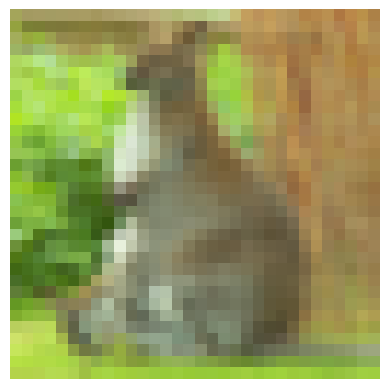

ResNet112_None
False | Predicetd squirrel | Actual kangaroo  | Confidence 94.52%


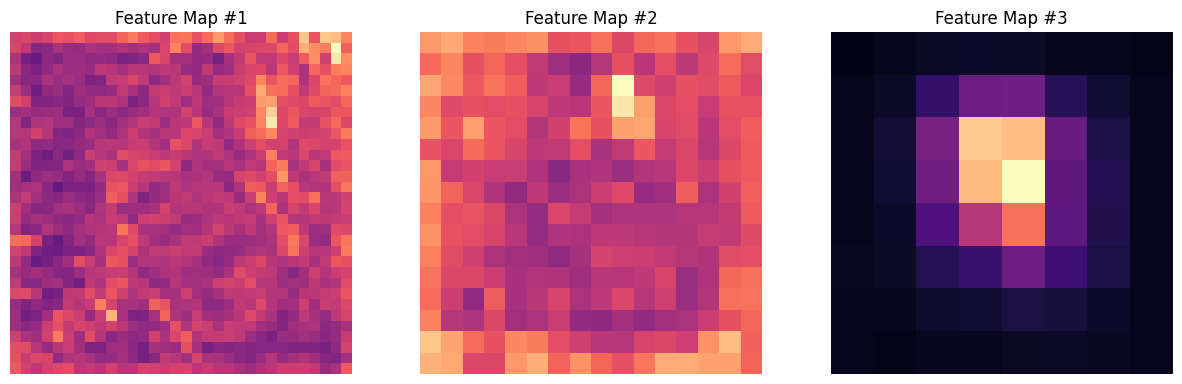

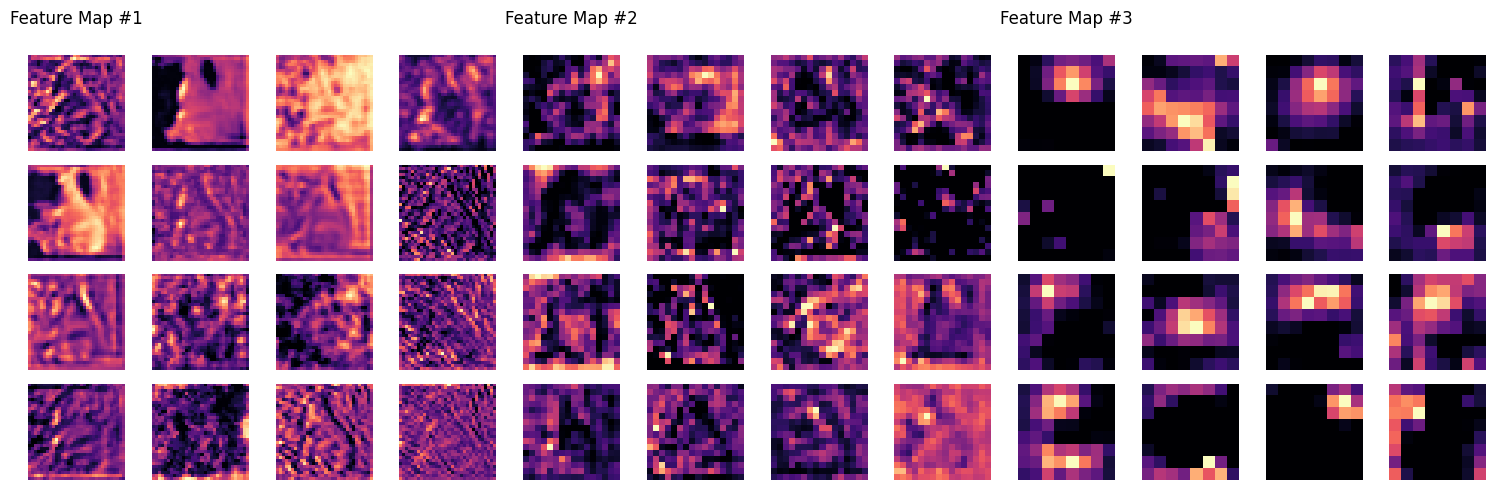




ResNet56_None
True | Predicetd kangaroo | Actual kangaroo  | Confidence 59.35%


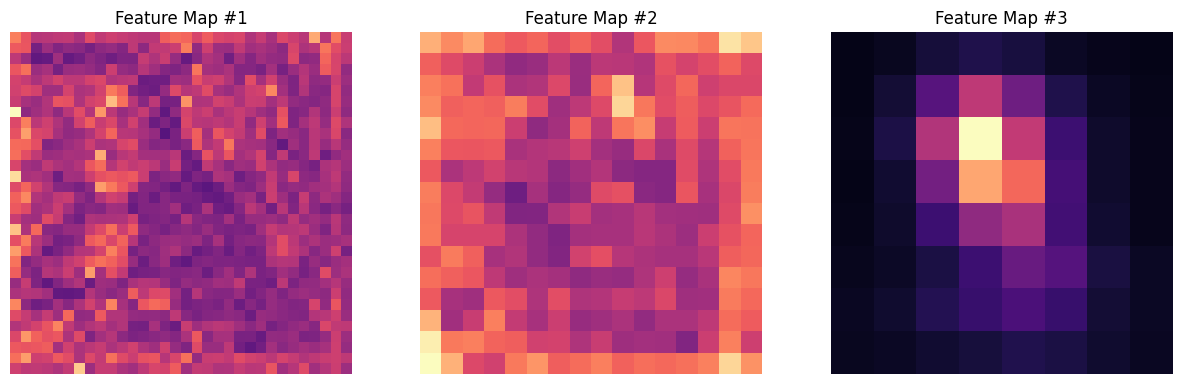

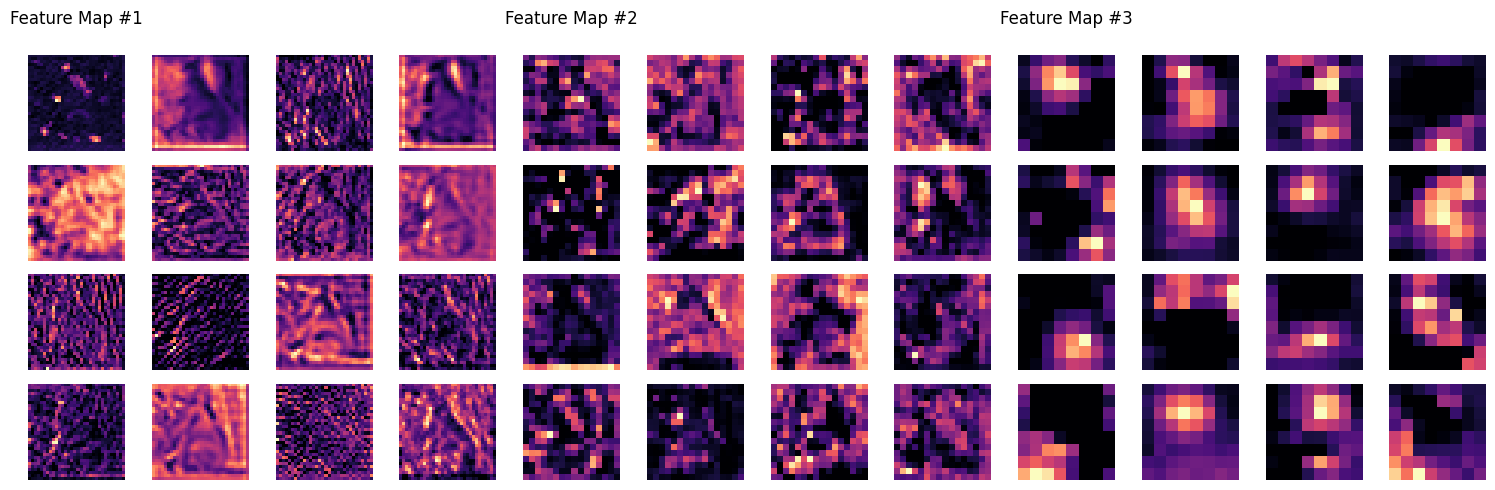


ResNet56_kd
True | Predicetd kangaroo | Actual kangaroo  | Confidence 96.07%


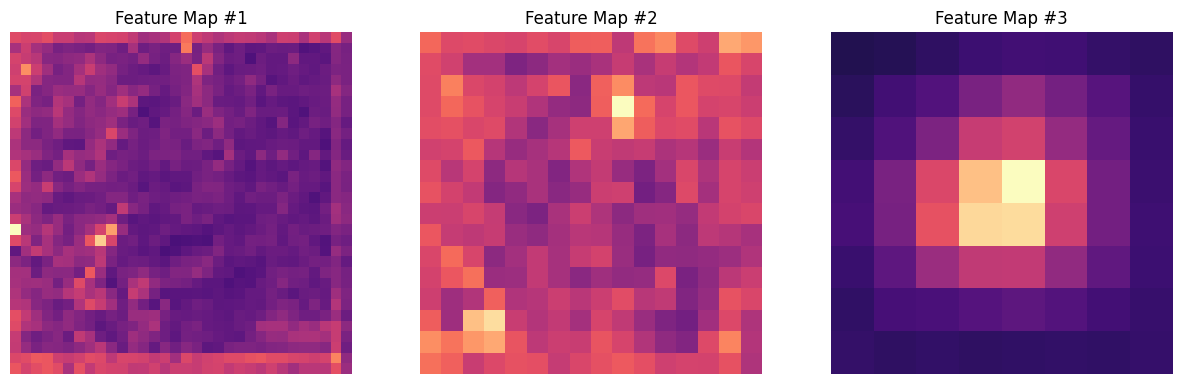

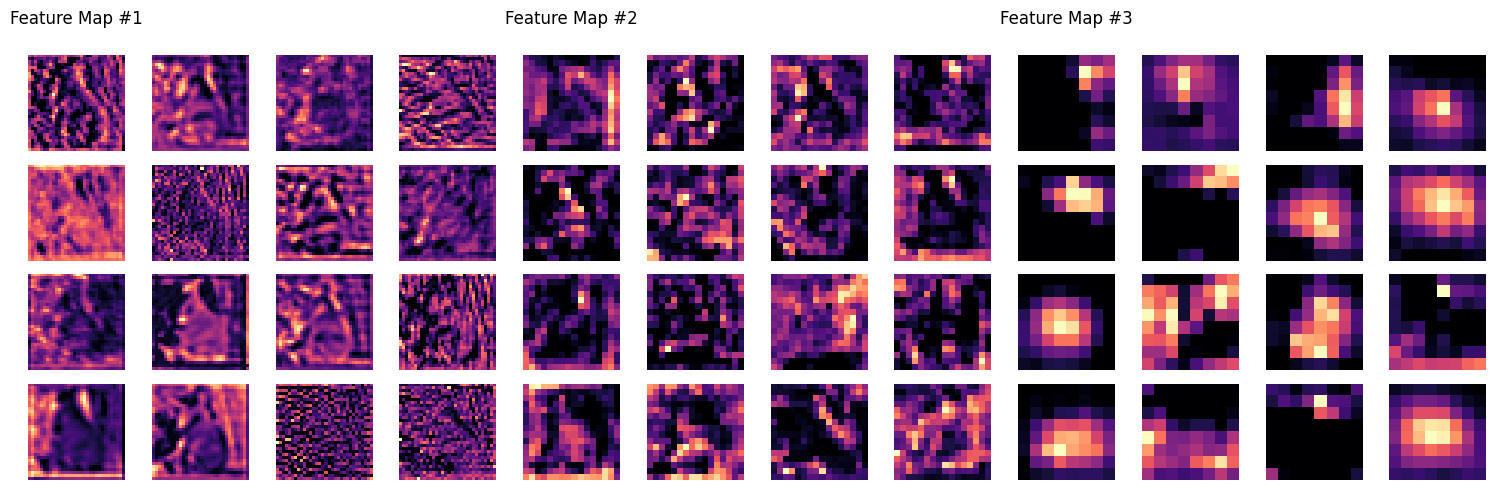


ResNet56_ft
False | Predicetd squirrel | Actual kangaroo  | Confidence 86.20%


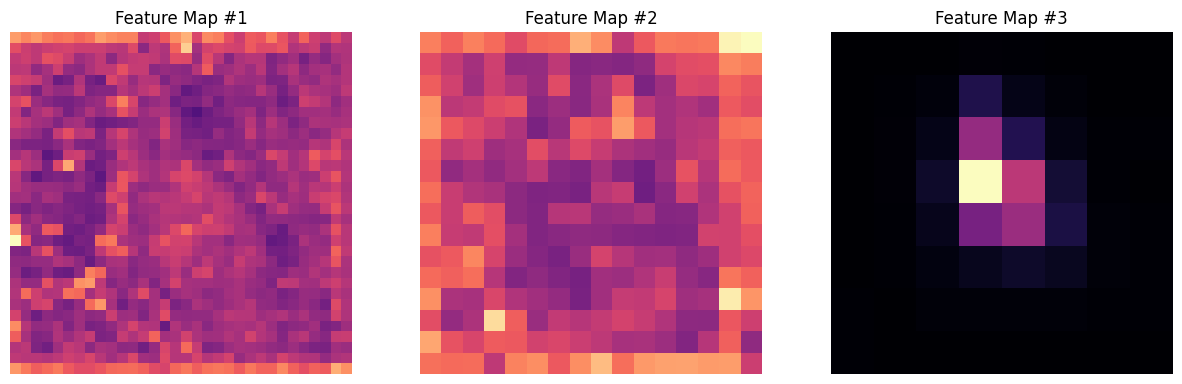

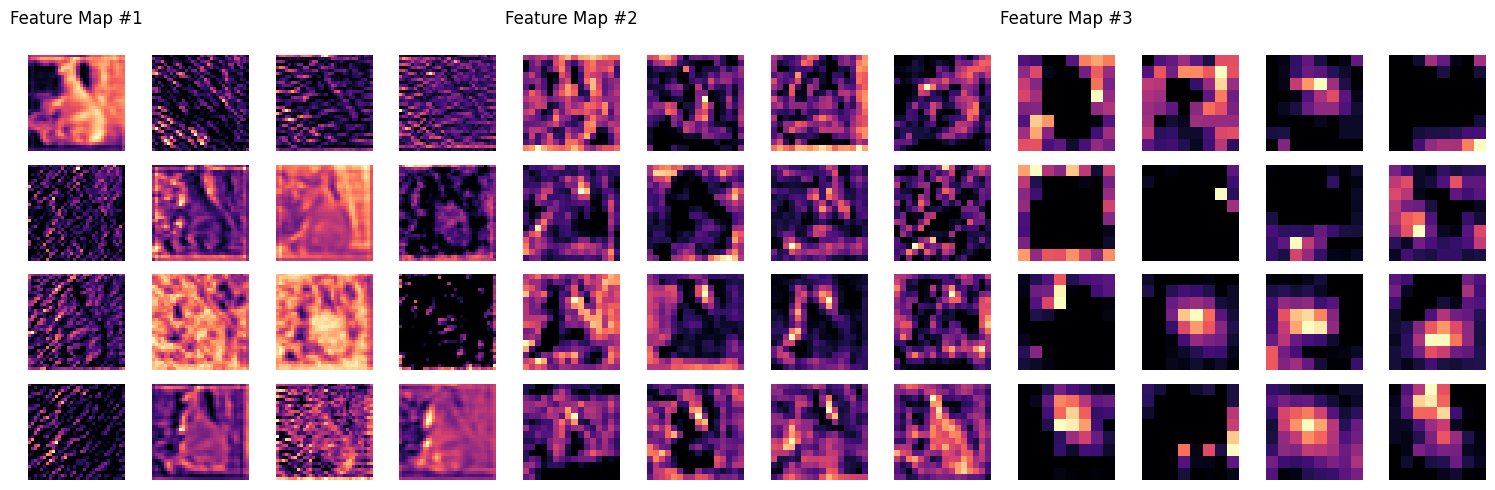


ResNet56_td
True | Predicetd kangaroo | Actual kangaroo  | Confidence 52.13%


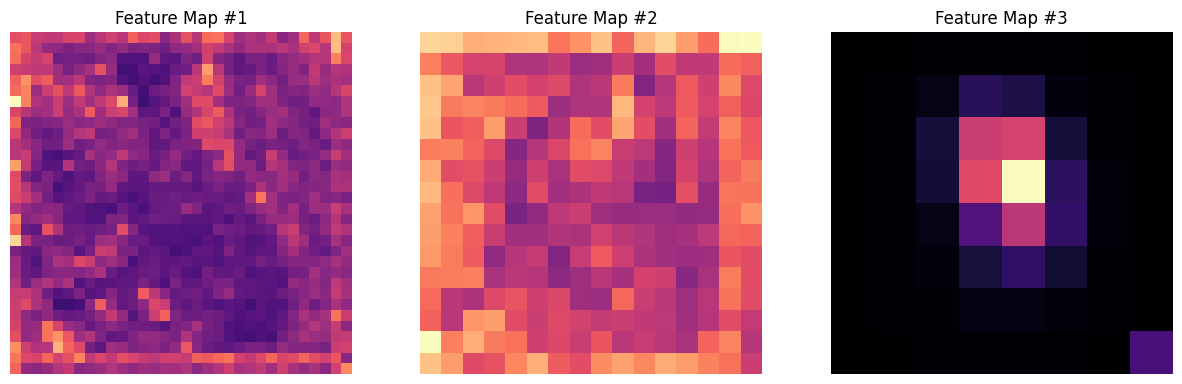

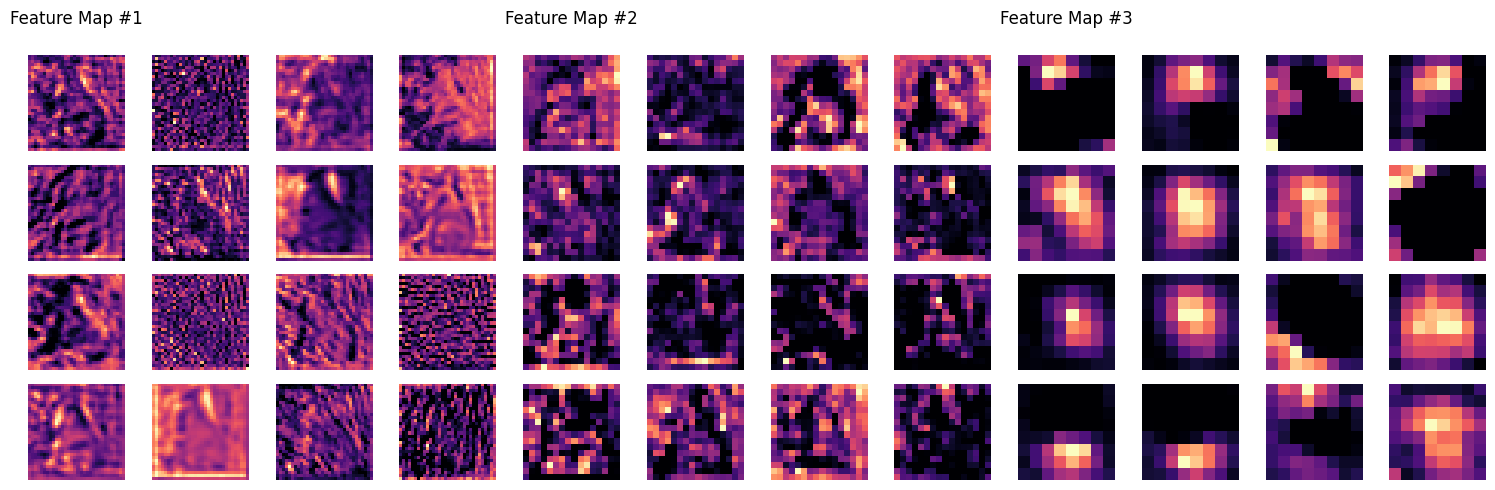




ResNet20_None
True | Predicetd kangaroo | Actual kangaroo  | Confidence 90.92%


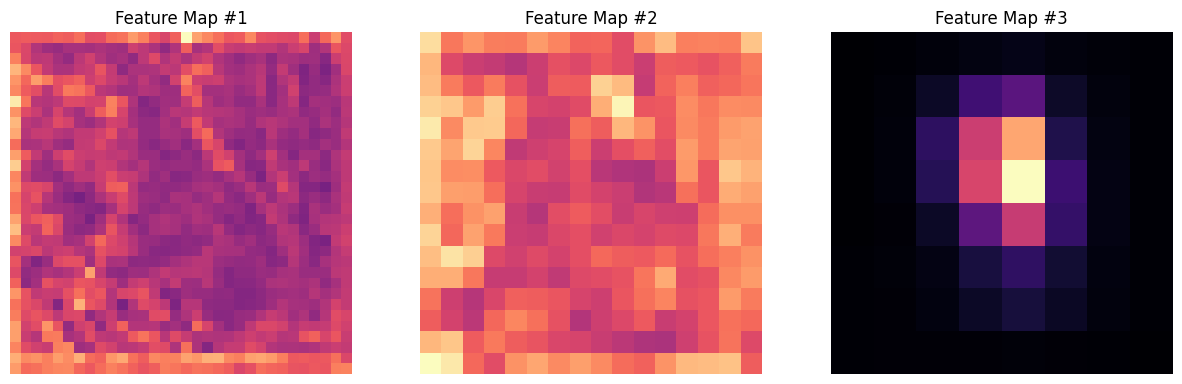

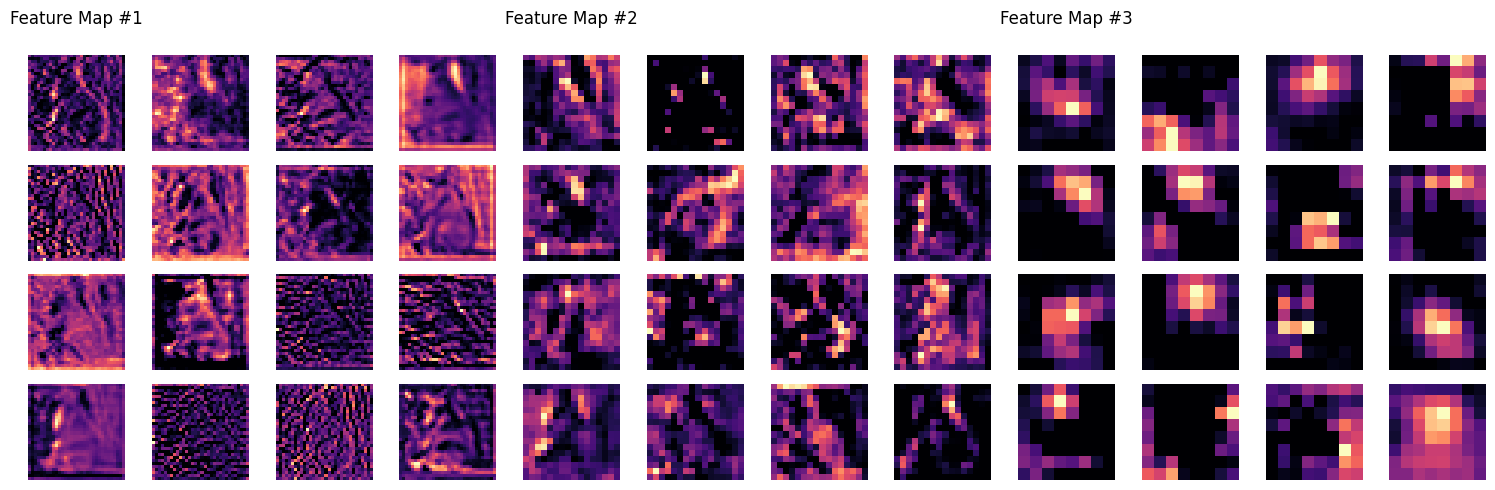


ResNet20_kd
False | Predicetd rabbit | Actual kangaroo  | Confidence 53.81%


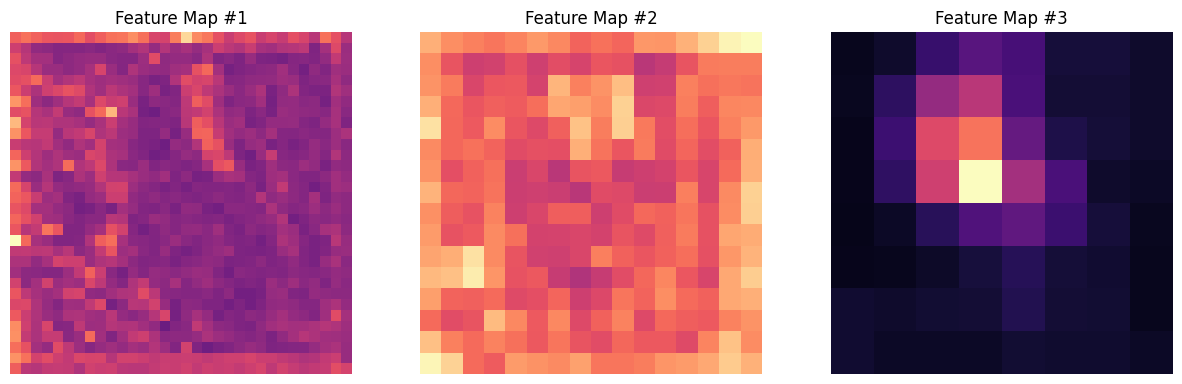

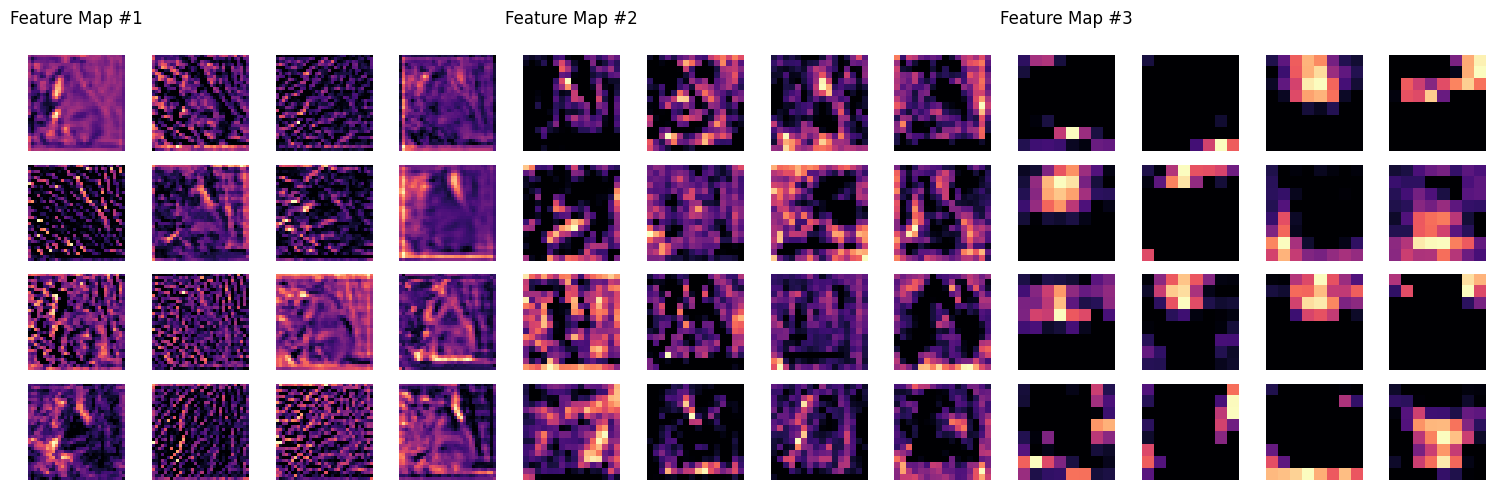


ResNet20_ft
True | Predicetd kangaroo | Actual kangaroo  | Confidence 60.40%


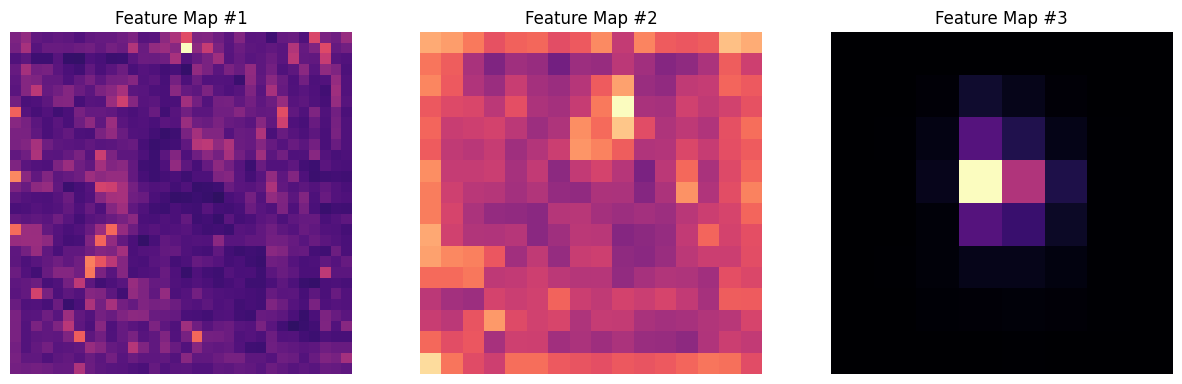

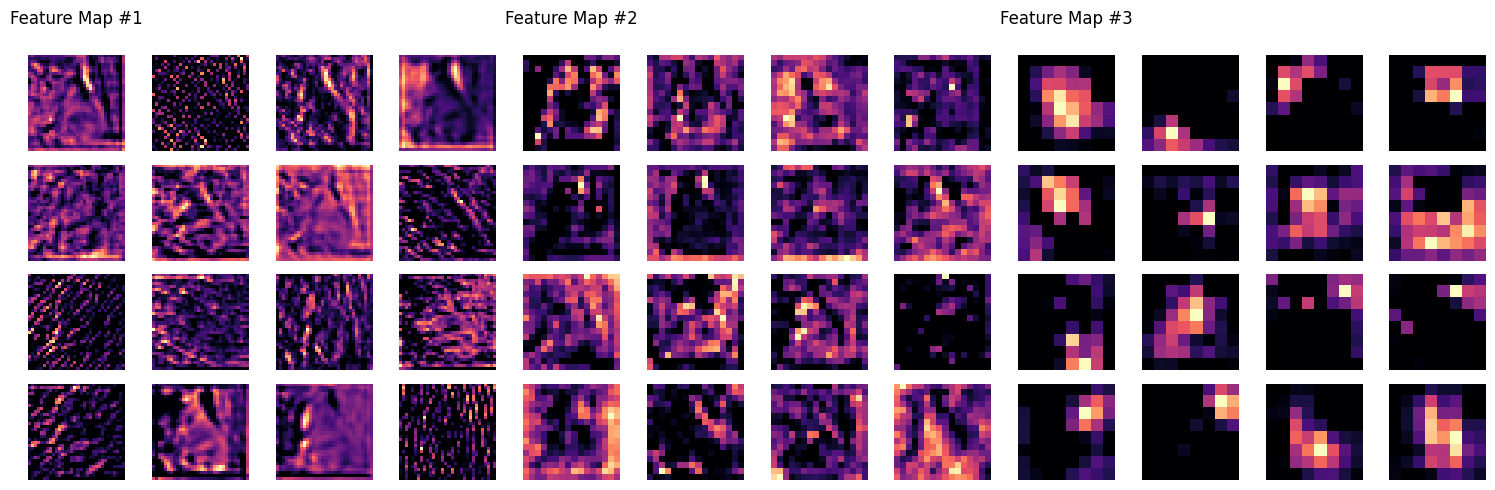


ResNet20_td
False | Predicetd squirrel | Actual kangaroo  | Confidence 50.75%


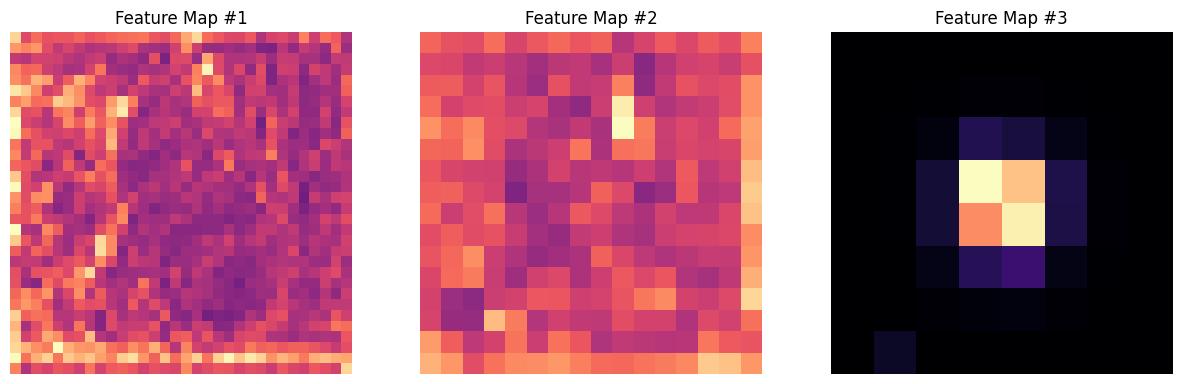

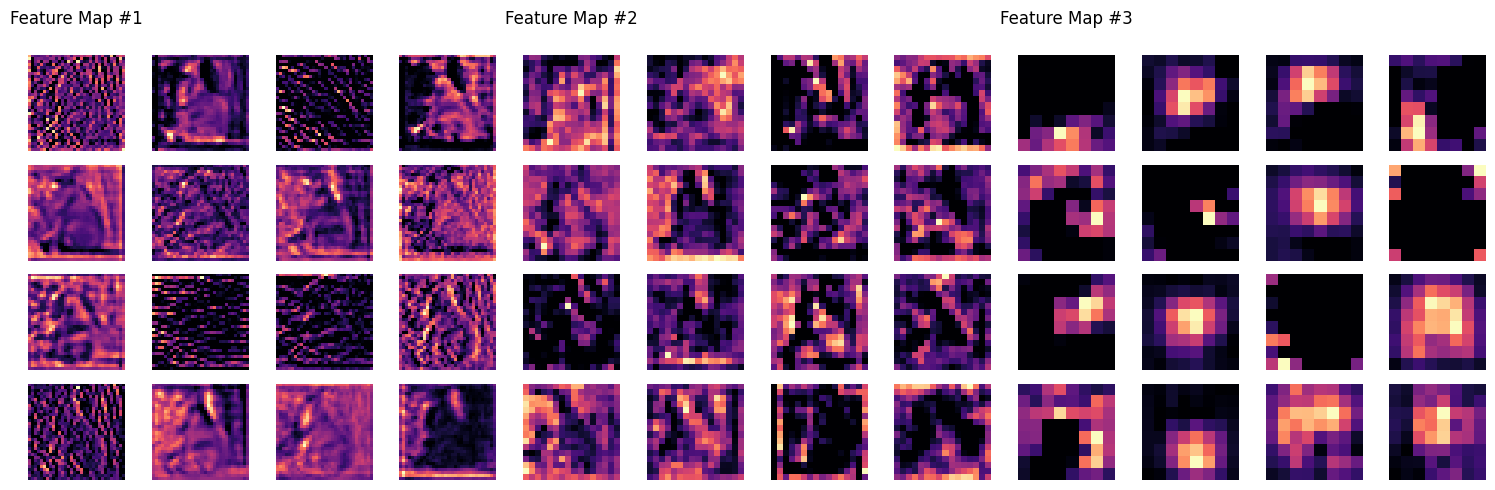




ResNetBaby_None
True | Predicetd kangaroo | Actual kangaroo  | Confidence 66.23%


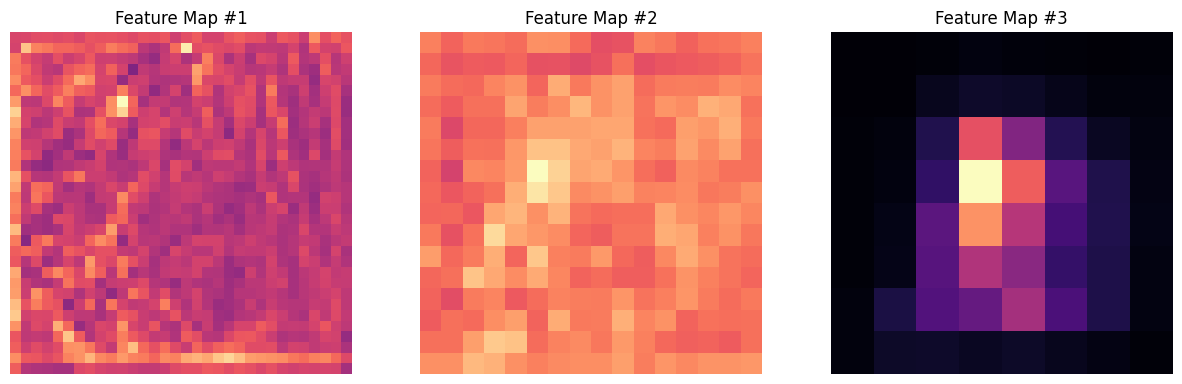

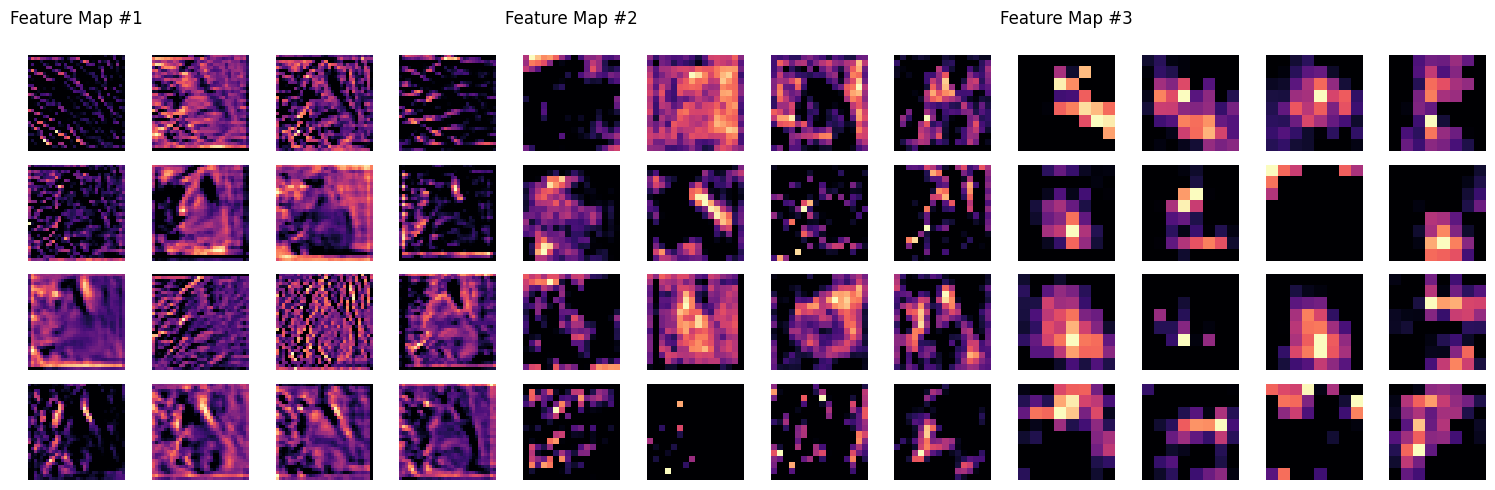


ResNetBaby_kd
True | Predicetd kangaroo | Actual kangaroo  | Confidence 50.43%


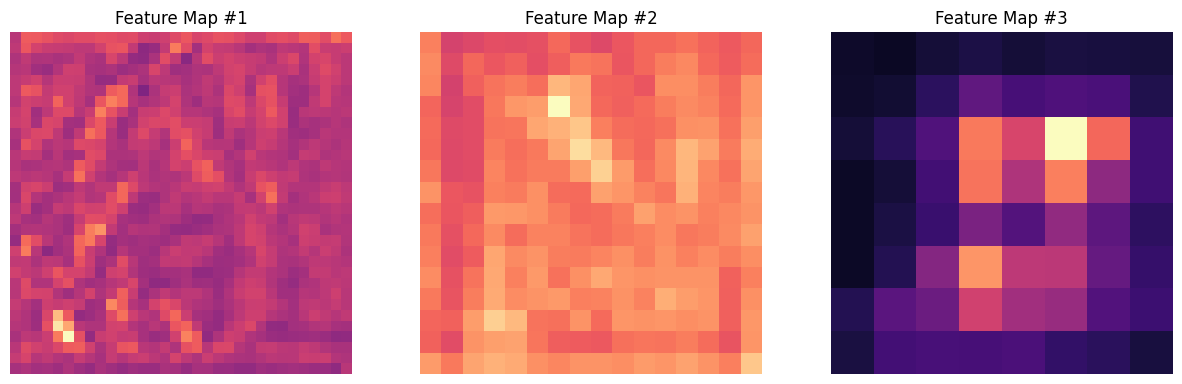

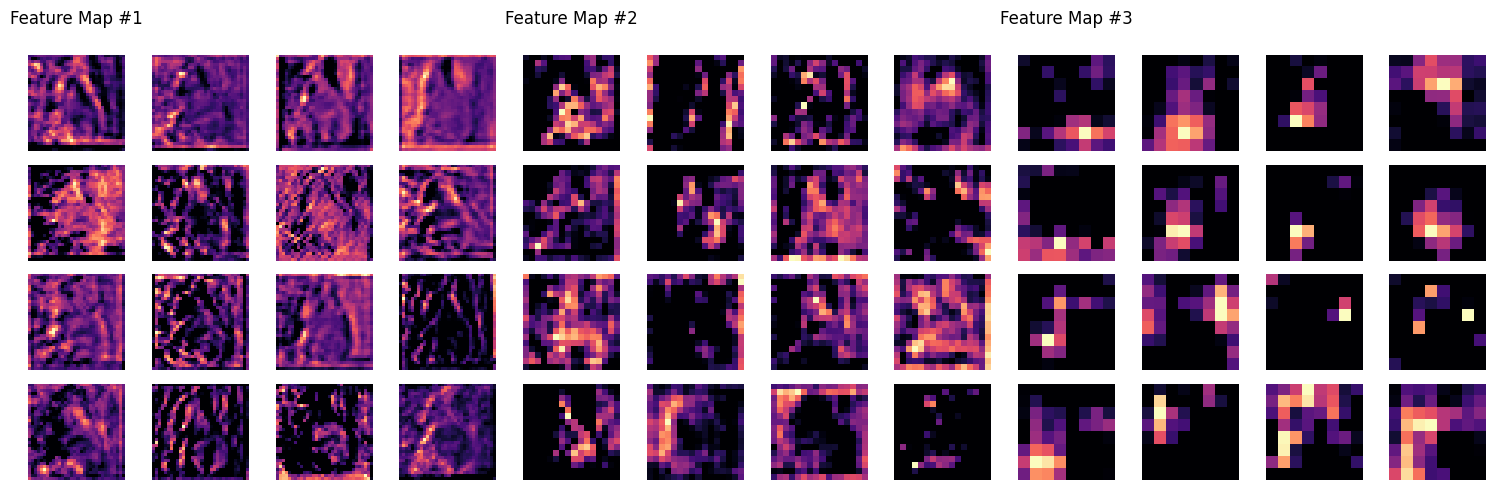


ResNetBaby_ft
True | Predicetd kangaroo | Actual kangaroo  | Confidence 64.15%


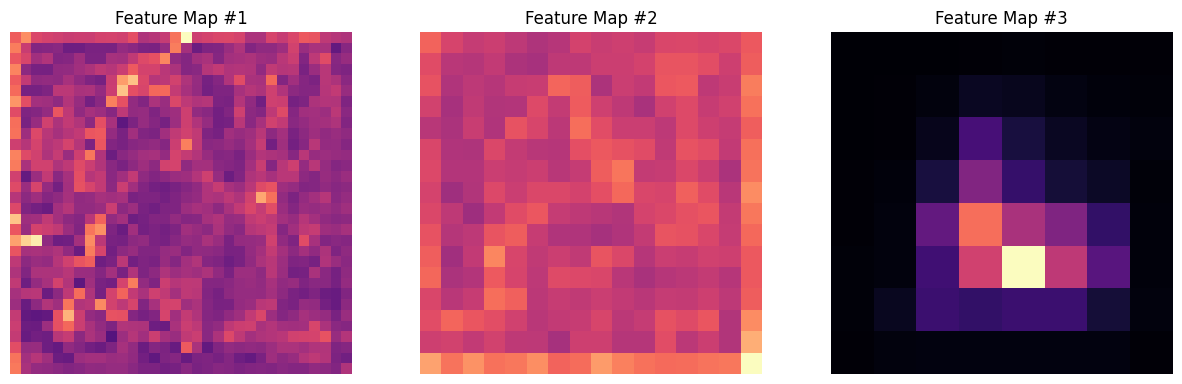

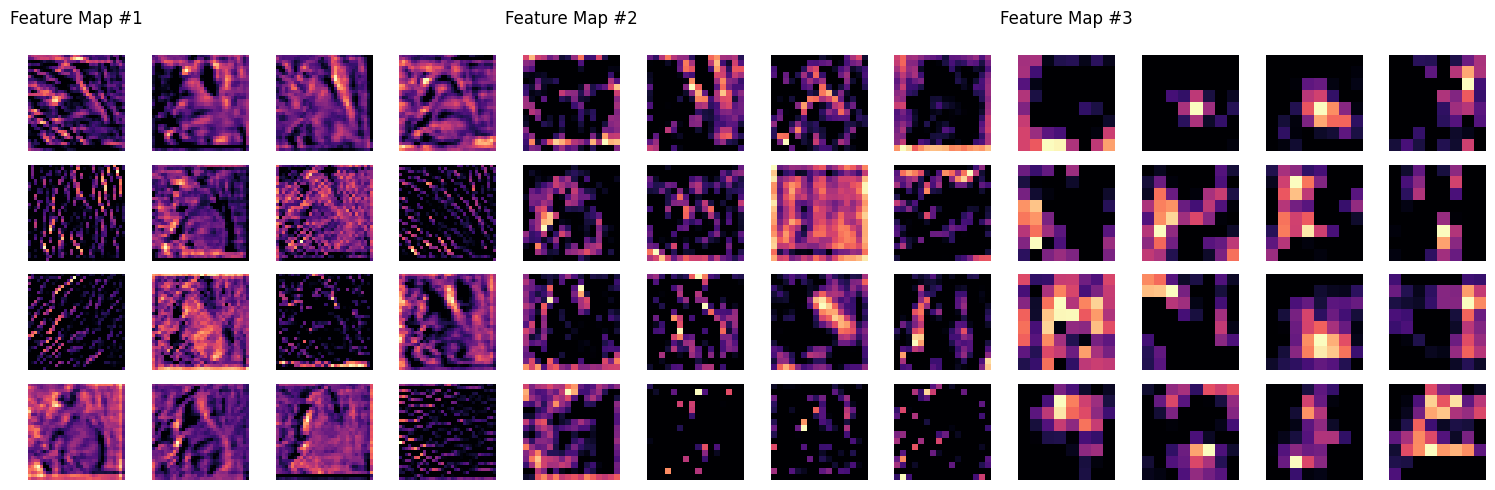


ResNetBaby_td
True | Predicetd kangaroo | Actual kangaroo  | Confidence 53.97%


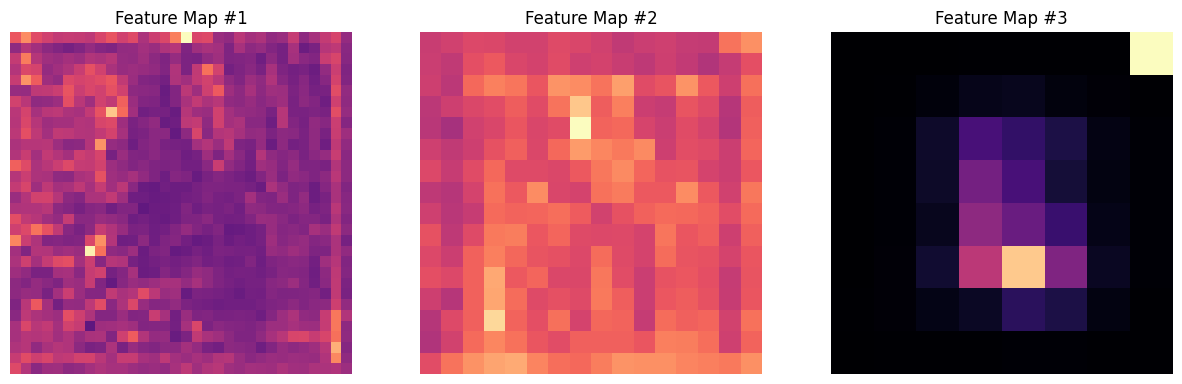

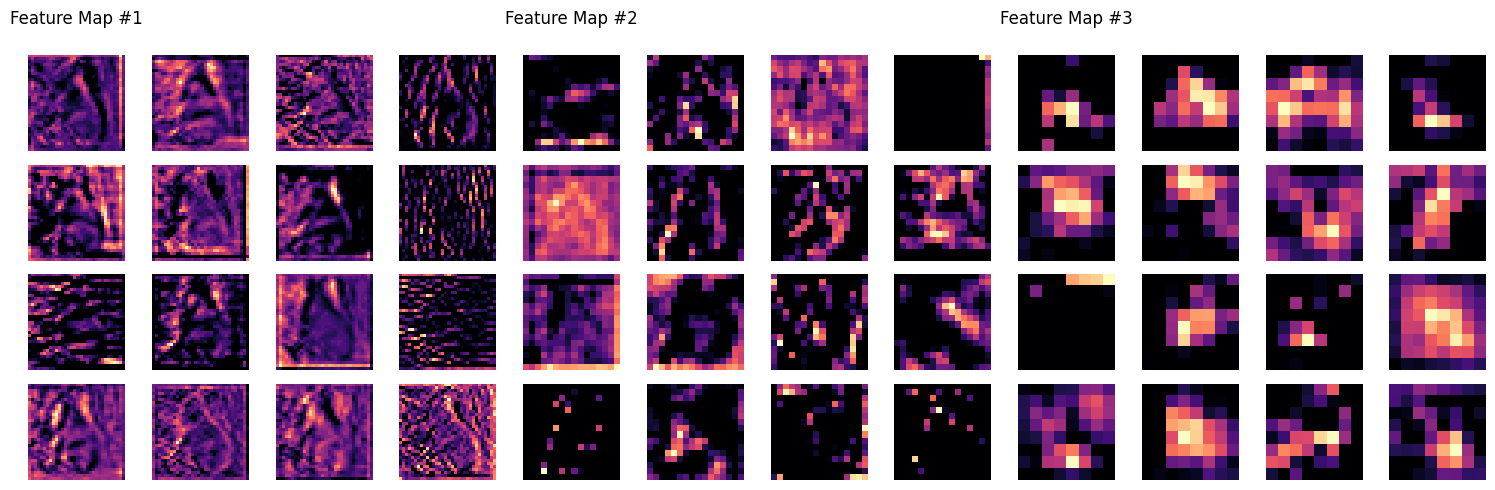

In [7]:
# show_random_feature_map()
sample_idx = random.randint(0,9999)
print(sample_idx)
show_sample(sample_idx)
for model in ['ResNet112', 'ResNet56', 'ResNet20', 'ResNetBaby']:
    for dist_type in ['None', 'kd', 'ft', 'td']:
        key = f'{model}_{dist_type}'
        if key in current:
            print(key)
            print_sample_data(sample_idx, batch[key])
            visualize_processed_feature_map(sample_idx, batch[key])
            visualize_channels(sample_idx, batch[key])
            print()
    print("="*200,"\n\n")

In [32]:
def compute_wavelet_energy(feature_map, wavelet='db1', level=2):
    energies = []
    for c in range(feature_map.shape[1]):  # Iterate over channels
        fm_np = feature_map[0, c].detach().cpu().numpy()
        coeffs = pywt.wavedec2(fm_np, wavelet, level=level)
        high_freq_energy = 0
        for detail in coeffs[1:]:  # Each detail is a tuple of arrays
            for subband in detail:
                high_freq_energy += np.sum(subband**2)
        energies.append(high_freq_energy)
    
    energies = torch.tensor(energies)
    avg = energies.mean().item()
    return avg

def compute_skewness(feature_map):
    flat_fm = feature_map.flatten().detach().cpu().numpy()
    skewness = skew(flat_fm)
    return skewness

def compute_lowpass_residuals(feature_map, kernel_size=3, sigma=1.0):
    blur = GaussianBlur(kernel_size, sigma)
    denoised_fm = blur(feature_map)
    residuals = torch.norm(feature_map - denoised_fm, p=2)
    return residuals.item()

def compute_frequency_entropy(feature_map):
    channels = feature_map.shape[1]
    entropies = []
    for c in range(channels):
        fm = feature_map[0, c]  
        fm_fft = fft.fft2(fm)
        power_spectrum = torch.abs(fm_fft)**2
        probs = power_spectrum / (power_spectrum.sum() + 1e-10)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10))
        entropies.append(entropy)
    
    entropies = torch.tensor(entropies)
    avg = entropies.mean()
    return avg.item()

def compute_iqr(feature_map):
    flat_fm = feature_map.flatten()
    q75, q25 = torch.quantile(flat_fm, torch.tensor([0.75, 0.25],device=device))
    iqr = q75 - q25
    return iqr.item()

def compute_high_freq_power(feature_map):
    channels = feature_map.shape[1]
    high_freq_powers = []
    for c in range(channels):
        fm = feature_map[0, c] 
        fm_fft = fft.fft2(fm)
        power_spectrum = torch.abs(fm_fft)**2
        high_freq_power = power_spectrum[int(fm.shape[0]/2):, int(fm.shape[1]/2):].sum()
        high_freq_powers.append(high_freq_power)
    
    high_freq_powers = torch.tensor(high_freq_powers)
    avg = high_freq_powers.mean().item()
    return avg

def compute_cv(feature_map):
    mean = torch.mean(feature_map)
    std = torch.std(feature_map)
    cv = mean / (std.abs() + 1e-10)
    return cv.item()

def compute_kurtosis(feature_map):
    flat_fm = feature_map.flatten().detach().cpu().numpy()
    return kurtosis(flat_fm)

def compute_entropy(feature_map): 
    feature_map = feature_map - feature_map.min()  
    sum_fm = feature_map.sum()
    if sum_fm == 0:  # Avoid division by zero
        return torch.tensor(0.0, device=feature_map.device)
    probs = feature_map / sum_fm
    entropy = -torch.sum(probs * torch.log(probs + 1e-10))
    return entropy.item()

def compute_average(feature_map):
    return feature_map.mean().item()

def compute_std(feature_map):
    return feature_map.std().item()

metrics = { 
    "Average": compute_average,
    "STD": compute_std,
    "Kurtosis": compute_kurtosis,
    "Wavelet High-Frequency Energy": compute_wavelet_energy,
    "Low-Pass Filter Residuals": compute_lowpass_residuals,
    "Frequency Entropy": compute_frequency_entropy,
    "IQR": compute_iqr,
    "High-Frequency Power": compute_high_freq_power,
    "Coefficient of Variation": compute_cv,
    "Skewness": compute_skewness,
    "Total Entropy": compute_entropy,
}
    

In [7]:
def analyze_feature_map_multiple_samples(batch_model, title, fidx, process=False, batch_size=1000):
    results = {"Feature Map": title}
    for name, func in metrics.items():
        number = 0
        for i in range(batch_size):
            feature_map = batch_model[i]['feature_map'][fidx].unsqueeze(0)
            number += func(process_feature_map(feature_map) if process else feature_map)
        number /= batch_size
        results.update({name: round(number,4)})
    return results

def analyze_feature_map_to_table(feature_map_list, titles):
    rows = []
    for feature_map, title in zip(feature_map_list, titles):
        results = {"Feature Map": title}  # Add title as a column
        results.update({name: round(func(feature_map), 4) for name, func in metrics.items()})
        rows.append(results)
    return rows
    # try:
    #     df.to_excel("feature_map_metrics.xlsx", index=False)  # index=False keeps it as a column
    #     print("Saved to 'feature_map_metrics.xlsx'")
    # except ModuleNotFoundError:
    #     print("Error: Install 'openpyxl' to save to Excel (pip install openpyxl)")

In [8]:
temp = {"Feature Map": ""}
for name, func in metrics.items():
    temp.update({name: 0})

for i in range(3):
    rows = []
    for key, value in batch.items():
        rows.append(analyze_feature_map_multiple_samples(batch[key], key, i))

    rows.append(temp)
    rows.append(temp)

    for key, value in batch.items(): # Process feature map before calculating stats
        rows.append(analyze_feature_map_multiple_samples(batch[key], key, i, process=True))

    rows.append(temp)
    rows.append(temp)


    random_fmap = torch.randn(1, 64, 8, 8).to(device)
    squashed_random_fmap = process_feature_map(random_fmap)
    rows += analyze_feature_map_to_table([random_fmap, squashed_random_fmap], ['Random', 'Random Squashed'])


    df = pd.DataFrame(rows)
    df.to_excel(f'metrics_fmaps_{i}.xlsx')
    print(df.to_string(index=False))

    Feature Map  Average    STD  Kurtosis  Wavelet High-Frequency Energy  Low-Pass Filter Residuals  Frequency Entropy    IQR  High-Frequency Power  Coefficient of Variation  Skewness  Total Entropy
                  0.0000 0.0000    0.0000                         0.0000                     0.0000             0.0000 0.0000                0.0000                    0.0000    0.0000         0.0000
                  0.0000 0.0000    0.0000                         0.0000                     0.0000             0.0000 0.0000                0.0000                    0.0000    0.0000         0.0000
                  0.0000 0.0000    0.0000                         0.0000                     0.0000             0.0000 0.0000                0.0000                    0.0000    0.0000         0.0000
                  0.0000 0.0000    0.0000                         0.0000                     0.0000             0.0000 0.0000                0.0000                    0.0000    0.0000         0.0000
     

In [64]:
data = pd.read_excel("../metrics_fmaps_2.xlsx")  # Third document
data = data.loc[data["Average"] != 0].drop(columns=["Unnamed: 0"])
normal_fmaps = data.iloc[0:13]
processed_fmaps = data.iloc[13:26]
fm_table_names = ["Normal", "Attention Map"]
# print(normal_fmaps.to_string(index=False))
for table_idx, table in enumerate([normal_fmaps, processed_fmaps]):
    rn56 = table[table["Feature Map"].isin(["ResNet56_None", "ResNet56_kd", "ResNet56_ft", "ResNet56_td"])]
    rn20 = table[table["Feature Map"].isin(["ResNet20_None", "ResNet20_kd", "ResNet20_ft", "ResNet20_td"])]
    rnb = table[table["Feature Map"].isin(["ResNetBaby_None", "ResNetBaby_kd", "ResNetBaby_ft", "ResNetBaby_td"])]

    table_arch_names = ["ResNet56", "ResNet20", "ResNetBaby"]
    for arch_idx, netarch in enumerate([rn56, rn20, rnb]):
        print(netarch.to_string(index=False))
        netarch = netarch.set_index("Feature Map")
        corr_matrix = netarch.corr()
        print(corr_matrix.to_string(index=False))

        break
    break


  Feature Map  Average    STD  Kurtosis  Wavelet High-Frequency Energy  Low-Pass Filter Residuals  Frequency Entropy    IQR  High-Frequency Power  Coefficient of Variation  Skewness  Total Entropy
ResNet56_None   0.8609 1.4864   19.4841                        68.0903                    27.5665             2.3555 1.0974              374.1172                    0.5751    3.5675         7.3002
  ResNet56_ft   1.1452 2.0576   20.9887                       149.1038                    41.8253             2.4719 1.4470              830.4063                    0.5600    3.7069         7.2686
  ResNet56_kd   0.8105 1.3742   16.8094                        51.7755                    22.6037             2.2006 1.0084              180.1409                    0.5882    3.4011         7.3210
  ResNet56_td   1.3275 2.9908 1066.1988                       413.3099                   116.5085             2.1249 1.5407             5287.6791                    0.4446   24.2769         7.3531
  Average      

In [12]:
import pandas as pd

# Load each table from xlsx files (replace with your file paths)
data1 = pd.read_excel("../metrics_fmaps_0.xlsx")  # First document
data2 = pd.read_excel("../metrics_fmaps_1.xlsx")  # Second document
data3 = pd.read_excel("../metrics_fmaps_2.xlsx")  # Third document

# Function to compute correlations with Total Entropy only
def compute_entropy_correlations(df, table_name):
    df = df.loc[df["Average"] != 0].drop(columns=["Unnamed: 0", "Feature Map"])
    
    print(df.to_string(index=False),"\n") 

    corr_matrix = df.corr()


    print(corr_matrix.to_string(index=False)) 
    entropy_correlations = corr_matrix.loc["Total Entropy"]
    
    # Print results
    print(f"\nCorrelations with Total Entropy for {table_name}:")
    for metric, corr_value in entropy_correlations.items():
        if metric != "Total Entropy":  # Skip self-correlation
            print(f"{metric}: {corr_value:.4f}")

# Run for each table
for fm_idx, data in enumerate([data1, data2, data3]):
    subtable1 = data.iloc[0:13].loc[data["Average"] != 0]
    subtable2 = data.iloc[15:28].loc[data["Average"] != 0]
    fm_names = ["Normal", "Attention Map"]
    for table_idx, table in enumerate([subtable1, subtable2]):
        ft_subtable = table[table["Feature Map"].isin(["ResNet56_ft", "ResNet20_ft", "ResNetBaby_ft"])]
        kd_subtable = table[table["Feature Map"].isin(["ResNet56_kd", "ResNet20_kd", "ResNetBaby_kd"])]
        td_subtable = table[table["Feature Map"].isin(["ResNet56_td", "ResNet20_td", "ResNetBaby_td"])]
        none_subtable = table[table["Feature Map"].isin(["ResNet112_None", "ResNet56_None", "ResNet20_None", "ResNetBaby_None"])]
        table_method_names = ["ft_subtable", "kd_subtable", "td_subtable", "none_subtable"]
        for method_idx, table_method in enumerate([ft_subtable, kd_subtable, td_subtable, none_subtable]):
            compute_entropy_correlations(table_method, f"Table {fm_idx+1}, {fm_names[table_idx]}, {table_method_names[method_idx]}")
            print('\n'*3)
    print("\n", "============================================"*2, "\n")

 Average    STD  Kurtosis  Wavelet High-Frequency Energy  Low-Pass Filter Residuals  Frequency Entropy    IQR  High-Frequency Power  Coefficient of Variation  Skewness  Total Entropy
  0.6290 0.5869    1.8575                       218.8502                    41.6826             3.0136 0.8537            60960.7001                    1.0757    1.1472         9.2435
  0.8781 0.6886    0.8033                       208.5884                    41.9860             2.2837 1.0471            63177.7025                    1.2783    0.7588         9.3583
  0.5819 0.5589    2.7115                       186.6320                    38.2742             2.9861 0.8870            50596.0310                    1.0484    1.1904         9.2056 

  Average       STD  Kurtosis  Wavelet High-Frequency Energy  Low-Pass Filter Residuals  Frequency Entropy       IQR  High-Frequency Power  Coefficient of Variation  Skewness  Total Entropy
 1.000000  0.998313 -0.950921                       0.347667                